In [1]:
import h5py
from dspeed import build_dsp
import numpy as np
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
import scipy.special as sp
import scipy.optimize as opt
import multiprocessing as mp

In [ ]:
### PRELIMINARY ANALYSIS OF DATA FROM NEW DETECTORS CARRIED OUT IN PETER KAMMELS ROOM ###

In [115]:
names = ["150um Alphas", "150um Pulser", "Hole Back", "1 mm Detector Alphas", "1 mm Detector Pulser"]

file1 = "raw/DataR_CH1@DT5730_1463_alpha_split.lh5" # path to raw file
file2 = "raw/DataR_CH1@DT5730_1463_pulse_split.lh5"
file3 = "raw/DataR_CH1@DT5730_1463_hole_backside.lh5"
file4 = "raw/DataR_CH1@DT5730_1463_hole_frontside.lh5"
file5 = "raw/DataR_CH1@DT5730_1463_hole_pulser.lh5"
all_files = [file1, file2, file3, file4, file5]
dsp_file_ex = "processed/DataR_CH1@DT5730_1463_alpha_split_dsp.lh5" # path to output dsp file but we dont need this here
out1 = "processed/150_alpha/150alpha"
out2 = "processed/150_pulse/150pulse"
out3 = "processed/hole_back/hole_back"
out4 = "processed/hole_front/hole_front"
out5 = "processed/hole_pulse/hole_pulse"
all_outs = [out4, out5]

In [11]:
dsp_config = {
    "outputs": ["bl", "wf_blsub"],
    "processors": {
        "bl, bl_sig, bl_slope, bl_intercept": {
            "function": "linear_slope_fit",
            "module": "dspeed.processors",
            "args": ["waveform[:1000]", "bl", "bl_sig", "bl_slope", "bl_intercept"],
            "unit": ["ADC", "ADC", "ADC", "ADC"]
        },
        "wf_blsub": {
                "function": "subtract",
                "module": "numpy",
                "args": ["waveform", "bl", "wf_blsub"],
                "unit": "ADC"
            }
    }    
}

In [12]:
def process_data(file, out, config=dsp_config):
    out_path = out
    
  
    build_dsp(
        f_raw=file, 
        f_dsp=out_path,
        lh5_tables = f"CompassEvent",
        dsp_config = config,
        write_mode = 'r'
    )


In [60]:
process_data(file1, out1)
process_data(file2, out2)
process_data(file3, out3)
process_data(file4, out4)
process_data(file5, out5)


Processing table CompassEvent:  41%|####      | 6400/15625 [00:03<00:05, 1760.78 rows/s]

Processing table CompassEvent:  45%|####4     | 6400/14372 [00:03<00:04, 1808.49 rows/s]

Processing table CompassEvent:  25%|##5       | 6400/25590 [00:03<00:10, 1825.11 rows/s]

Processing table CompassEvent:  22%|##2       | 6400/28689 [00:03<00:13, 1677.24 rows/s]

Processing table CompassEvent:  85%|########4 | 6400/7557 [00:03<00:00, 1803.08 rows/s]

In [53]:
####### NECESSARY GLOBAL VARIABLES ########
bins = np.linspace(0, 2000, 3001)          #
binwidth = bins[1] - bins[0]              #
bin_centers = bins[:-1] + binwidth/2      #
cmadc = 1310.5 #ADC
cme = 5804.77 #keV
adc2e = cme/cmadc
ebins = np.linspace(0, 10000, 10001)
ebinwidth = ebins[1] - ebins[0]
ebin_centers = ebins[:-1] + ebinwidth/2

print(binwidth)                           #
print(bins)                               #
print(bin_centers)                        #
###########################################
print(adc2e)

0.6666666666666666
[0.00000000e+00 6.66666667e-01 1.33333333e+00 ... 1.99866667e+03
 1.99933333e+03 2.00000000e+03]
[3.33333333e-01 1.00000000e+00 1.66666667e+00 ... 1.99833333e+03
 1.99900000e+03 1.99966667e+03]
4.429431514689051


In [102]:
def select_n_cut(dsp_file, type="adc"):
    f = h5py.File(dsp_file)
    wf_blsub = f['CompassEvent']['wf_blsub']['values'][:]
    f.close()
    max_heights = np.max(wf_blsub, axis=1)
    #max_heights = max_heights[max_heights < 1700]
    #max_heights = max_heights[max_heights > 1000]
    if type == "adc":
        print("ADC")
        return max_heights
    else:
        return max_heights*adc2e
        

def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


# Define the fit function 
def fit_func(x, mu, sigma, eta, tau1, tau2):
    return 0.5 * (((1-eta)/tau1 * np.exp((x-mu)/tau1 + 0.5*(sigma/tau1)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau1)))
                  + (eta/tau2 * np.exp((x-mu)/tau2 + 0.5*(sigma/tau2)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau2))))


# Define the cdf of the fit function
def cdf_fit_func(x, A, mu, sigma, eta, tau1, tau2):
    return A * np.cumsum(fit_func(x, mu, sigma, eta, tau1, tau2)) * ebinwidth  # have to change between bins and ebins manually ick


# Iminuit optimizer function takes actual data and returns the optimized fit and params 
def optimizer(counts, gimme_moar=False, binns = bins):
    c = cost.ExtendedBinnedNLL(counts, binns, cdf_fit_func)
    m = Minuit(c, A=10000, mu=600, sigma=5, eta=0.25, tau1=20, tau2=20)
    m.limits["A"] = (2000, 14000)
    m.limits["sigma"] = (0.5,35)
    m.limits["tau1"] = (0.05, 1000)
    m.limits["tau2"] = (0.05, 1000)
    m.limits['eta'] = (0,1)
    var = m.migrad()  # need to call migrad but prob dont need the return variable
    A_fit = m.values['A']
    mean_fit = m.values['mu']
    std_fit = m.values['sigma']
    eta_fit = m.values['eta']
    tau1_fit = m.values['tau1']
    tau2_fit = m.values['tau2']
    fwhm_fit = 2.355*std_fit
    energy_fwhm = fwhm_fit*3271.2/mean_fit
    energy_resolution = fwhm_fit/mean_fit

    minuit_fit = A_fit * fit_func(binns, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit)


    if gimme_moar:
        return minuit_fit, c, A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit, fwhm_fit, energy_fwhm, energy_resolution
    else:
        return minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution


# Plotting function which plots the fit and the data along with some other info
def plot_fit(noise_cut, minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution, g_fit_package = False, rise = False, flat = False):
    #plt.plot(x, test_fit, color='green', label='Test Fit', alpha = 0.75)
    plt.hist(noise_cut, bins=bins, color='blue', alpha=0.5)
    plt.plot(bins, minuit_fit, color='red', label='Minuit Fit', alpha = 0.75)
    if g_fit_package:
        plt.plot(bin_centers, g_fit_package[0], color='black', label='Half-Gaussian Fit')
        plt.text(0.02, 0.55, 'Half-Gaussian Fit Energy_Resolution:' + str(round(g_fit_package[1]*100, 2)) + '%', transform=plt.gca().transAxes)
        plt.text(0.02, 0.6, 'Half-Gaussian Fit Energy_FWHM:' + str(round(g_fit_package[2], 2)) + ' keV', transform=plt.gca().transAxes)
    plt.axvline(mean_fit, color='black', linestyle='--', label='Minuit Mean: ' + str(round(mean_fit, 2)))
    plt.axvline(mean_fit + fwhm_fit/2, color='black', linestyle=':', label='Minuit FWHM: ' + str(round(fwhm_fit, 2)))
    plt.axvline(mean_fit - fwhm_fit/2, color='black', linestyle=':')
    plt.text(0.02, 0.65, 'Minuit Energy Resolution: ' + str(round(energy_resolution*100, 2)) + '%', transform=plt.gca().transAxes)
    plt.text(0.02, 0.7, 'Minuit Energy FWHM: ' + str(round(energy_fwhm, 2)) + ' keV', transform=plt.gca().transAxes)
    plt.xlim(550, 607)

    if rise and flat:
        plt.title(f'Gd-148 Alpha Spectrum [Rise: {rise:.2f}us, Flat: {flat:.2f}us]')
    else:
        plt.title('Gd-148 Alpha Spectrum')
    plt.xlabel('Energy (ADC)')
    plt.ylabel('Counts')
    #plt.ylim(1e-2, 2e2)
    #plt.yscale('log')
    plt.legend()
    #plt.ylim(1e-1, 2e3)
    #plt.yscale('log')
    plt.show()

def plot_heat_map(e_fwhm_array, rises, flats):
    figgy, axs = plt.subplots(figsize=(10, 10))
    im = axs.imshow(e_fwhm_array, origin='lower')
    round_rises = np.around(rises, 2)
    round_flats = np.around(flats, 2)
    axs.set_xticks(np.arange(len(flats)), labels=round_flats)
    axs.set_yticks(np.arange(len(rises)), labels=round_rises)
    plt.setp(axs.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    axs.set_title("Energy Resolution vs Rise and Flat Times")
    axs.set_xlabel("Flat Time (us)")
    axs.set_ylabel("Rise Time (us)")
    plt.colorbar(im)
    figgy.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
    plt.show()


In [99]:
def fit_half_gauss(data, walk, gimme_all=False, binns=bins):
    if np.array_equal(binns, ebins):
        binnwidth = ebinwidth
        binn_centers = ebin_centers
    else:
        binnwidth = binwidth
        binn_centers = bin_centers
    counts, _ = np.histogram(data, bins=binns)
    max_counts = np.max(counts)
    max_index = np.argmax(counts)
    walk_left = max_index - walk
    e_left = binns[walk_left]                
    cut_counts = counts[walk_left:]
    cut_data = data[data > e_left]
    x = binn_centers[walk_left:]
    popt, pcov = opt.curve_fit(gaussian, x, cut_counts, p0=[max_counts, binn_centers[max_index], 5])
    mean_temp = popt[1]
    stdev_temp = popt[2]
    e_res_temp = stdev_temp*2.355/mean_temp
    if gimme_all:
        return e_res_temp, popt, cut_data, cut_counts, x, counts, max_index, walk_left, e_left, max_counts
    else:
        return e_res_temp, popt

In [80]:
all_data = []
for i in range(len(all_outs)):
    maxes = select_n_cut(all_outs[i], type="adc")
    all_data.append(maxes)

ADC
ADC


In [81]:
all_params = []
all_cut_data = []
all_gauss = []
all_e_res = []

for data in all_data:
    e_res, popt, cut_data, cut_counts, x, counts, max_index, walk_left, e_left, max_counts = fit_half_gauss(data, 5, gimme_all=True)
    all_e_res.append(e_res)
    all_params.append(popt)
    all_cut_data.append(cut_data)
    gauss = gaussian(bin_centers, popt[0], popt[1], popt[2])
    all_gauss.append(gauss)


In [93]:
all_data2 = []
for i in range(len(all_outs)):
    maxes2 = select_n_cut(all_outs[i], type="energy")
    all_data2.append(maxes2)

all_data2[0] = all_data2[0][all_data2[0] > 5400]
#all_data2[1] = all_data2[1][all_data2 > 5400]

In [94]:
all_params2 = []
all_cut_data2 = []
all_gauss2 = []
all_e_res2 = []

for data in all_data2:
    e_res2, popt2, cut_data2, cut_counts2, x2, counts2, max_index2, walk_left2, e_left2, max_counts2 = fit_half_gauss(data, int(5*adc2e), gimme_all=True, binns=ebins)
    all_e_res2.append(e_res2)
    all_params2.append(popt2)
    all_cut_data2.append(cut_data2)
    gauss2 = gaussian(ebin_centers, popt2[0], popt2[1], popt2[2])
    all_gauss2.append(gauss2)


In [103]:
minfit = optimizer(all_data2[0], binns = ebins)

ValueError: n and xe have incompatible shapes along dimension 0, xe must be longer by one element along each dimension

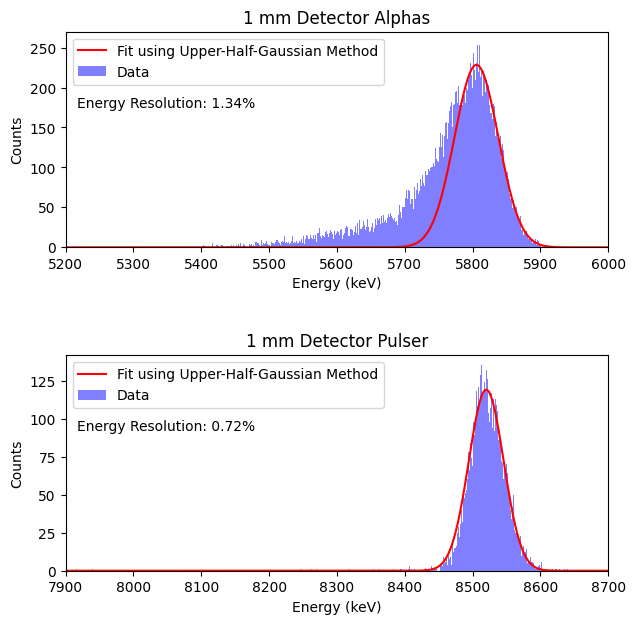

In [120]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7))
bounds = [(5200,6000),(7900,8700)]
chkn_parm = [1310.5, 1923.5]

for i, gauss2 in enumerate(all_gauss2):
    ax[i].plot(ebin_centers, gauss2, color='r', label='Fit using Upper-Half-Gaussian Method')
    ax[i].hist(all_data2[i], bins=ebins, alpha=0.5, color='b', label='Data')
    #if i == 0:
      #  ax[i].plot(ebin_centers, minfit, label='Minuit Fit')
    #ax[i].hist(all_cut_data[i], bins=bins, alpha=0.5)
    ax[i].set_xlim(bounds[i][0], bounds[i][1])
    ax[i].text(0.02, 0.65, f'Energy Resolution: {all_e_res[i]*100:.2f}%', transform=ax[i].transAxes)
    ax[i].set_title(f'{names[i+3]}')
    ax[i].set_xlabel('Energy (keV)')
    ax[i].set_ylabel('Counts')
    #ax[i].axvline(chkn_parm[i], color='black', linestyle='--', label=str(chkn_parm[i]))
    ax[i].legend()
    
plt.subplots_adjust(hspace=0.5)

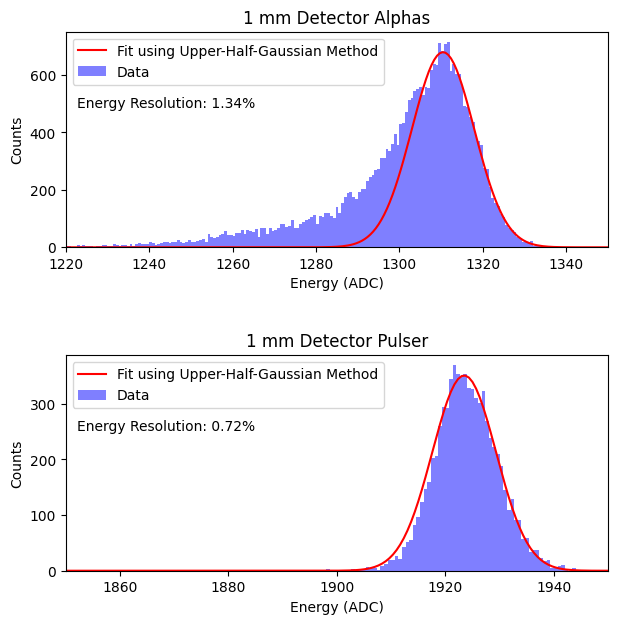

In [116]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7))
bounds = [(1220,1350),(1850,1950)]
parm = [1310.5, 1923.5]

for i, gauss in enumerate(all_gauss):
    ax[i].plot(bin_centers, gauss, color='r', label='Fit using Upper-Half-Gaussian Method')
    ax[i].hist(all_data[i], bins=bins, alpha=0.5, color='b', label='Data')
    #ax[i].hist(all_cut_data[i], bins=bins, alpha=0.5)
    ax[i].set_xlim(bounds[i][0], bounds[i][1])
    ax[i].text(0.02, 0.65, f'Energy Resolution: {all_e_res[i]*100:.2f}%', transform=ax[i].transAxes)
    ax[i].set_title(f'{names[i+3]}')
    ax[i].set_xlabel('Energy (ADC)')
    ax[i].set_ylabel('Counts')
    #ax[i].axvline(parm[i], color='black', linestyle='--', label=str(parm[i]))
    ax[i].legend()
    
plt.subplots_adjust(hspace=0.5)

In [77]:
print(all_params)

[array([ 360.82516426, 1285.68108534,    7.70951365]), array([ 404.36933557, 1895.68381263,    7.16483143]), array([  52.28811227, 1245.72384983,   14.94280775]), array([ 512.91838176, 1310.28137297,    7.55506785]), array([ 263.94440562, 1923.09657478,    6.17413226])]


In [107]:
popt, cut_data, cut_counts, x, counts, max_index, walk_left, e_left, max_counts = fit_half_gauss(all_data[0], 5, gimme_all=True)

(1100.0, 1400.0)

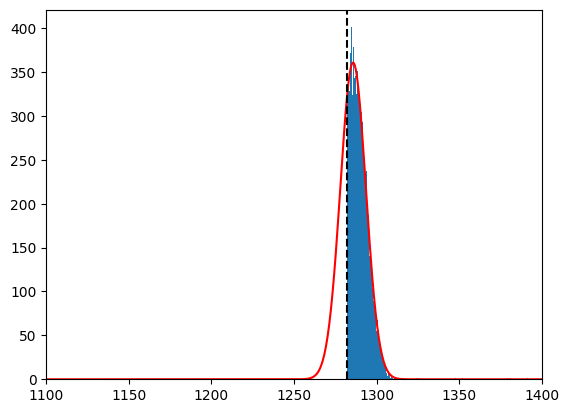

In [109]:
plt.hist(cut_data, bins=bins)
plt.bar(x, cut_counts, width=binwidth, alpha=0.5)
gauss_fit = gaussian(bin_centers, *popt)
plt.plot(bin_centers, gauss_fit, color='red')
plt.axvline(e_left, color='black', linestyle='--')
plt.xlim(1100, 1400)